In [1]:
from botorch.models import SingleTaskGP, ModelListGP
import torch
import time
import psutil
import os
from functools import wraps
from contextlib import redirect_stdout
import logging
import json


from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import SumMarginalLogLikelihood
from gpytorch.kernels import (
    ScaleKernel,
    MaternKernel,
    RBFKernel,
)


# =========================================================
# Monitoring Utilities
# ============================================================

def _log_memory():
    """Log CPU & GPU memory usage."""

    # CPU
    process = psutil.Process(os.getpid())
    cpu_mem = process.memory_info().rss / 1024**2
    print(f"[CPU] Memory: {cpu_mem:.2f} MB")

    # GPU
    if torch.cuda.is_available():
        gpu_alloc = torch.cuda.memory_allocated() / 1024**2
        gpu_res = torch.cuda.memory_reserved() / 1024**2
        print(f"[GPU] Alloc: {gpu_alloc:.2f} MB | Reserved: {gpu_res:.2f} MB")


def _log_condition_number(model_list_gp):
    """Log condition number of kernel matrix for each objective."""

    for i, model in enumerate(model_list_gp.models):

        train_x = model.train_inputs[0]

        with torch.no_grad():
            K = model.covar_module(train_x).evaluate().cpu()

            eigvals = torch.linalg.eigvalsh(K)

            cond = eigvals.max() / eigvals.min()

        print(f"[Objective {i}] Condition #: {cond.item():.3e}")

        if cond > 1e10:
            print("⚠ WARNING: Kernel matrix is ill-conditioned!")


# --- Logging 配置 ---
logger = logging.getLogger("BO_Monitor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    ch = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    logger.addHandler(ch)




# ============================================================
# Decorator
# ============================================================

def monitor(runtime=True, memory=True, condition=False):
    def decorator(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):
            if not getattr(self, "debug", False):
                return func(self, *args, **kwargs)

            # 確保類別中有存儲紀錄的容器
            if not hasattr(self, 'performance_history'):
                self.performance_history = []

            # 紀錄開始資訊
            start_time = time.perf_counter()
            process = psutil.Process(os.getpid())
            
            # 執行函數
            result = func(self, *args, **kwargs)
            
            # 計算指標
            end_time = time.perf_counter()
            elapsed = end_time - start_time
            cpu_mem = process.memory_info().rss / 1024**2
            
            entry = {
                "iteration": getattr(self, "current_iter", "N/A"), # 追蹤當前疊代次數
                "function": func.__name__,
                "runtime_sec": round(elapsed, 4),
                "cpu_memory_mb": round(cpu_mem, 2),
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
            }

            if torch.cuda.is_available():
                entry["gpu_alloc_mb"] = round(torch.cuda.memory_allocated() / 1024**2, 2)

            # 如果需要紀錄條件數 (僅針對 fit 後的模型)
            if condition and getattr(self, "model", None) is not None:
                cond_list = []
                for i, m in enumerate(self.model.models):
                    with torch.no_grad():
                        K = m.covar_module(m.train_inputs[0]).evaluate()
                        eigvals = torch.linalg.eigvalsh(K)
                        cond = (eigvals.max() / eigvals.min()).item()
                        cond_list.append(cond)
                entry["condition_numbers"] = cond_list

            # 儲存到物件歷史紀錄
            self.performance_history.append(entry)
            
            # 同時印出日誌供參考
            logger.info(f"Finished {func.__name__} - {entry}")
            
            return result
        return wrapper
    return decorator




class BaselineGPEmulator:
    """
    Baseline Multi-Objective GP Emulator
    =====================================

    This class implements a multi-objective Gaussian Process (GP)
    surrogate model using independent SingleTaskGP models.

    Mathematical Form:

        y_k(z) = m_k(z) + g_k(z)

        m_k(z) : constant mean (default in SingleTaskGP)
        g_k(z) ~ GP(0, K_{θ_k})

    Each objective is modeled with an independent GP.

    Example:
        >>> import torch
        >>> from baseline_gp_emulator import BaselineGPEmulator
        >>>
        >>> # Generate training data
        >>> train_X = torch.rand(20, 3, dtype=torch.double)
        >>> train_Y = torch.rand(20, 2, dtype=torch.double)
        >>>
        >>> # Create emulator
        >>>
        >>> # method1 : RBF is defult
        >>> emulator = BaselineGPEmulator()  #defult = RBF
        >>>
        >>> # method2 : matern
        >>> emulator = BaselineGPEmulator(
        ...     kernel="matern"
        ... )
        >>>
        >>> # Fit model
        >>> model = emulator.fit(train_X, train_Y)
        >>>
        >>> # Make predictions
        >>> test_X = torch.rand(5, 3, dtype=torch.double)
        >>> mean, var = emulator.predict(test_X)
        >>>
        >>> mean.shape
        torch.Size([5, 2])
        >>> var.shape
        torch.Size([5, 2])
    """

    def __init__(
        self,
        device  = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        dtype   = torch.double,
        kernel    = "rbf",      # "rbf" or "matern"
        use_ard   = False,       # Whether to use Automatic Relevance Determination
        matern_nu = 2.5,         # Smoothness parameter for Matern kernel
        debug=False,   # Debug switch
        
    
    ):
        self.device = device
        self.dtype = dtype
        self.model = None
        self.mll = None

        self.kernel = kernel
        self.use_ard = use_ard
        self.matern_nu = matern_nu
        self.debug = debug
        self.performance_history = []
        self.current_iter = 0


    def _build_kernel(self, input_dim):

        """
        Construct covariance kernel based on configuration.

        If ARD is enabled, each input dimension has its own
        independent lengthscale parameter.
        """


        ard_dims = input_dim if self.use_ard else None

        if self.kernel == "matern":
            base_kernel = MaternKernel(
                nu=self.matern_nu,
                ard_num_dims=ard_dims,
            )
        else:  # default: RBF
            base_kernel = RBFKernel(
                ard_num_dims=ard_dims,
            )

        # ScaleKernel allows the model to learn an output scale parameter
        return ScaleKernel(base_kernel)


    @monitor(runtime=True, memory=True, condition=True)
    def fit(self, train_x: torch.Tensor, train_obj: torch.Tensor):
        """
        Fit the multi-objective GP surrogate model.

        Parameters
        ----------
        train_x : torch.Tensor
            Training inputs of shape (N, d)

        train_obj : torch.Tensor
            Training objectives of shape (N, k)

        Returns
        -------
        ModelListGP
            A ModelListGP containing independent SingleTaskGP models
            for each objective.
        """

        # If single objective (N,), convert to (N, 1)
        if train_obj.ndim == 1:
            train_obj = train_obj.unsqueeze(-1)

        input_dim = train_x.shape[-1]
        num_objectives = train_obj.shape[-1]

        models = []
        
        # Build one independent GP per objective
        for i in range(num_objectives):
            covar_module = self._build_kernel(input_dim)

            train_y = train_obj[..., i:i + 1]  # (N, 1)

            gp = SingleTaskGP(
                train_X=train_x,
                train_Y=train_y,
                outcome_transform=Standardize(m=1),
                covar_module=covar_module,
            )
            models.append(gp)

        # Combine independent GPs into ModelListGP
        self.model = ModelListGP(*models)

        # Define marginal log likelihood for multi-model case
        self.mll = SumMarginalLogLikelihood(
            self.model.likelihood, self.model
        )
        with open(os.devnull, 'w') as f:
            with redirect_stdout(f):
                fit_gpytorch_mll(self.mll)


        # Maximize marginal log likelihood
        fit_gpytorch_mll(self.mll)

        return self.model


    def save_performance_to_json(self, folder_path, filename="performance_report.json"):
            """
            將監控紀錄儲存至指定資料夾路徑。
            """
            # 1. 確保資料夾存在，若不存在則自動建立
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
                logger.info(f"Created directory: {folder_path}")

            # 2. 合併完整路徑
            full_path = os.path.join(folder_path, filename)

            # 3. 寫入 JSON
            try:
                with open(full_path, 'w', encoding='utf-8') as f:
                    json.dump(self.performance_history, f, indent=4, ensure_ascii=False)
                logger.info(f"Successfully saved performance metrics to: {full_path}")
            except Exception as e:
                logger.error(f"Failed to save JSON: {str(e)}")


    @torch.no_grad()
    def predict(self, X ):
        """
        Predict using the trained GP surrogate.

        Parameters
        ----------
        X : torch.Tensor or array-like
            Input locations of shape (n, d)

        Returns
        -------
        mean : torch.Tensor
            Posterior predictive mean of shape (n, k)

        var : torch.Tensor
            Posterior predictive variance of shape (n, k)
        """

        if self.model is None:
            raise RuntimeError("Model has not been fitted yet.")
        
        X = torch.as_tensor(X, dtype=self.dtype, device=self.device)
        posterior = self.model.posterior(X)
        mean = posterior.mean    # (n, k)
        var = posterior.variance # (n, k)

        return mean, var






In [ ]:
## matrix ScheffeMean
import torch
import itertools
import time
import psutil
import os
import logging
import json
from functools import wraps
from contextlib import redirect_stdout

from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import SumMarginalLogLikelihood
from gpytorch.means import Mean
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel

# ============================================================
# Optimized Mean Function: FastScheffeMean
# ============================================================
class ScheffeMean(Mean):
    """
    優化後的 Scheffé 混合多項式均值函數。
    利用張量廣播與掩碼矩陣消除 Python 迴圈，提升 GPU 運算效率。
    """
    def __init__(self, input_dim, order=1):
        super().__init__()
        self.input_dim = input_dim
        self.order = order

        if order < 1:
            raise ValueError("ScheffeMean requires order >= 1")

        # 1. 產生所有組合索引
        basis_indices = []
        for k in range(1, order + 1):
            basis_indices.extend(list(itertools.combinations(range(input_dim), k)))
        
        self.p = len(basis_indices)

        # 2. 建立掩碼矩陣 (Mask Matrix)
        # mask shape: (p, d), 代表 p 個項中哪些維度需要被相乘
        mask = torch.zeros(self.p, input_dim)
        for i, idx_tuple in enumerate(basis_indices):
            mask[i, list(idx_tuple)] = 1
        
        # 註冊為 buffer，會自動隨模型搬移至 GPU/CPU 並處理 dtype
        self.register_buffer("mask", mask)

        # 3. 學習參數 β
        self.register_parameter(
            name="beta",
            parameter=torch.nn.Parameter(torch.zeros(self.p)),
        )

    def forward(self, X):
        """
        X shape: (..., n, d)
        Returns: (..., n)
        """
        # 增加維度以便廣播: X -> (..., n, 1, d)
        X_expanded = X.unsqueeze(-2) 

        # 利用 X^1 = X, X^0 = 1 的特性計算各項乘積
        # F_elements: (..., n, p, d)
        F_elements = torch.pow(X_expanded, self.mask)
        
        # 對最後一個維度求積，得到每一項的基函數值 (..., n, p)
        F = torch.prod(F_elements, dim=-1)

        # 與權重 beta 做線性組合 (..., n)
        return torch.matmul(F, self.beta)

# ============================================================
# Monitoring Utilities & Decorator
# ============================================================
logger = logging.getLogger("BO_Monitor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    ch = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    logger.addHandler(ch)

def monitor(runtime=True, memory=True, condition=False):
    def decorator(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):
            if not getattr(self, "debug", False):
                return func(self, *args, **kwargs)
            if not hasattr(self, 'performance_history'):
                self.performance_history = []
            
            start_time = time.perf_counter()
            process = psutil.Process(os.getpid())
            
            result = func(self, *args, **kwargs)
            
            elapsed = time.perf_counter() - start_time
            cpu_mem = process.memory_info().rss / 1024**2
            
            entry = {
                "iteration": getattr(self, "current_iter", "N/A"),
                "function": func.__name__,
                "runtime_sec": round(elapsed, 4),
                "cpu_memory_mb": round(cpu_mem, 2),
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
            }
            if torch.cuda.is_available():
                entry["gpu_alloc_mb"] = round(torch.cuda.memory_allocated() / 1024**2, 2)
            
            self.performance_history.append(entry)
            logger.info(f"Finished {func.__name__} - {entry}")
            return result
        return wrapper
    return decorator



# ============================================================
# ScheffeTrendGPEmulator
# ============================================================
class ScheffeTrendGPEmulator:
    def __init__(
        self,
        device        = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        dtype         = torch.double,
        kernel        = 'rbf',
        use_ard       = False,
        matern_nu     = 2.5,
        scheffe_order = 2,
        debug         = False,
    ):
        self.device = device
        self.dtype = dtype
        self.kernel = kernel
        self.use_ard = use_ard
        self.matern_nu = matern_nu
        self.scheffe_order = scheffe_order
        self.debug = debug
        self.performance_history = []
        self.current_iter = 0
        self.model = None

    def _build_kernel(self, input_dim):
        ard_dims = input_dim if self.use_ard else None
        if self.kernel == "matern":
            base_kernel = MaternKernel(nu=self.matern_nu, ard_num_dims=ard_dims)
        else:
            base_kernel = RBFKernel(ard_num_dims=ard_dims)
        return ScaleKernel(base_kernel)

    @monitor(runtime=True, memory=True, condition=True)
    def fit(self, train_x: torch.Tensor, train_obj: torch.Tensor):
        # 確保數據類型與設備一致
        train_x = train_x.to(device=self.device, dtype=self.dtype)
        train_obj = train_obj.to(device=self.device, dtype=self.dtype)

        if train_obj.ndim == 1:
            train_obj = train_obj.unsqueeze(-1)

        input_dim = train_x.shape[-1]
        num_objectives = train_obj.shape[-1]
        models = []

        for i in range(num_objectives):
            covar_module = self._build_kernel(input_dim)

            # --- 使用 ScheffeMean ---
            mean_module = ScheffeMean(
                input_dim=input_dim,
                order=self.scheffe_order,
            ).to(device=self.device, dtype=self.dtype) 

            train_y = train_obj[..., i:i + 1]

            gp = SingleTaskGP(
                train_X=train_x,
                train_Y=train_y,
                mean_module=mean_module,
                outcome_transform=Standardize(m=1),
                covar_module=covar_module,
            )
            models.append(gp)

        self.model = ModelListGP(*models).to(device=self.device, dtype=self.dtype)
        self.mll = SumMarginalLogLikelihood(self.model.likelihood, self.model)

        # 靜默訓練過程
        with open(os.devnull, 'w') as f:
            with redirect_stdout(f):
                fit_gpytorch_mll(self.mll)

        return self.model


    def save_performance_to_json(self, folder_path, filename="performance_report.json"):
            """
            將監控紀錄儲存至指定資料夾路徑。
            """
            # 1. 確保資料夾存在，若不存在則自動建立
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
                logger.info(f"Created directory: {folder_path}")

            # 2. 合併完整路徑
            full_path = os.path.join(folder_path, filename)

            # 3. 寫入 JSON
            try:
                with open(full_path, 'w', encoding='utf-8') as f:
                    json.dump(self.performance_history, f, indent=4, ensure_ascii=False)
                logger.info(f"Successfully saved performance metrics to: {full_path}")
            except Exception as e:
                logger.error(f"Failed to save JSON: {str(e)}")


    @torch.no_grad()
    def predict(self, X):
        if self.model is None:
            raise RuntimeError("Model has not been fitted yet.")
        X = torch.as_tensor(X, dtype=self.dtype, device=self.device)
        posterior = self.model.posterior(X)
        return posterior.mean, posterior.variance

In [7]:

import torch
import pandas as pd
import os
import numpy as np
import json
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.transforms import Standardize, Normalize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.acquisition.multi_objective.logei import (
    qLogExpectedHypervolumeImprovement,
    qLogNoisyExpectedHypervolumeImprovement
)
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood




# 設定設備與型別
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
torch.set_default_dtype(dtype)
print('==='*5)
print('device = ',device)
print('==='*5)

FEATURE_COLS = [
    'AA001','AA002','AA004','AA005','AA006','AW001','AW003','AW004','AW005','AW014',
    'AX010','AX015','AX019','AX020','AX029','AX032','AX137','CM1002','CM1007','CM1008',
    'CP2002','FR001','FR002','FR006','FR007','FR008','FR015','FR058','GF001','GF006',
    'GF013','GF014','GF016','GF020','MF001','MF005','MF006','MF007','PR002','PR007',
    'PR009','PR016','PR020','PR022','PR024','SS004','SS010'
    ]
TARGET_COLS = ["SPGR", "TE"]


# =====================================================
# Oracle loader (standalone, aligned with colleague)
# =====================================================
def load_oracle(beta_csv_path):
    df = pd.read_csv(beta_csv_path)

    if "active" in df.columns:
        df = df[df["active"].astype(bool)].copy()

    # intercept
    inter = df[df["type"].str.lower() == "intercept_correction"]
    intercept = torch.tensor(
        inter.iloc[0][TARGET_COLS].astype(float).to_numpy(),
        device=device,
        dtype=dtype,
    )

    feat_to_idx = {f: i for i, f in enumerate(FEATURE_COLS)}

    # linear
    lin_df = df[df["type"].str.lower() == "linear"].copy()
    lin_df["feat"] = lin_df["feature"].str.extract(r"x\[(.+?)\]")
    lin_df["idx"] = lin_df["feat"].map(feat_to_idx)

    beta_lin = torch.zeros((2, len(FEATURE_COLS)), device=device, dtype=dtype)
    for _, r in lin_df.iterrows():
        beta_lin[:, int(r["idx"])] = torch.tensor(
            r[TARGET_COLS].astype(float).to_numpy(),
            device=device,
            dtype=dtype,
        )

    # interaction
    int_df = df[df["type"].str.lower() == "interaction"].copy()
    mats = int_df["feature"].str.extract(r"x\[(.+?)\]\*x\[(.+?)\]")
    int_df["i"] = mats[0].map(feat_to_idx)
    int_df["j"] = mats[1].map(feat_to_idx)

    pairs = torch.tensor(
        int_df[["i", "j"]].values.astype(int),
        device=device,
        dtype=torch.long,
    )

    beta_inter = torch.tensor(
        int_df[TARGET_COLS].astype(float).to_numpy(),
        device=device,
        dtype=dtype,
    ).T

    return {
        "intercept": intercept,
        "beta_lin": beta_lin,
        "pairs": pairs,
        "beta_inter": beta_inter,
    }



def oracle_function(X, oracle):
    intercept = oracle["intercept"]
    beta_lin = oracle["beta_lin"]
    pairs = oracle["pairs"]
    beta_inter = oracle["beta_inter"]

    lin = X @ beta_lin.T
    cross = X[:, pairs[:, 0]] * X[:, pairs[:, 1]]
    inter = cross @ beta_inter.T
    return intercept.unsqueeze(0) + lin + inter

device =  cuda


In [ ]:
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume


seed  = '39'
PATH  = "D:/Users/TingYuLin/Desktop/py12/MOBO/synthetic_data_sparse_constraint_seed_39.csv"
# PATH2 = f"./synthetic_data_sparse_seed_{seed}.csv"
N_ITER = 50
df = pd.read_csv(PATH)

train_x = torch.tensor(df[FEATURE_COLS].values/100, device=device, dtype=dtype)
train_obj = torch.tensor(df[TARGET_COLS].values, device=device, dtype=dtype)

hv_history = []
pareto_history = []
all_X = [train_x.detach().cpu().numpy().tolist()]  # 存初始 X
all_Y = [train_obj.detach().cpu().numpy().tolist()]  # 存初始 Y


print(train_obj.shape)
ref_point = torch.tensor([1.3654, 2.8482], dtype=dtype, device=device)



# SAVE_DIR = "D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_gp_result"
SAVE_DIR = "D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result"
FILE_NAME = f"final_performance_seed_{seed}.json"


BETA_CSV = "D:/Users/TingYuLin/Desktop/py12/MOBO/beta1.csv"
oracle = load_oracle(BETA_CSV)


# gp_base = BaselineGPEmulator(kernel = 'rbf',debug=True)
gp_Scheffe = ScheffeTrendGPEmulator(kernel = 'rbf', scheffe_order = 2, debug=True)
# corr_gp_base = CorrelationBaselineGPEmulator()
# corr_Scheffe = CorrelationScheffeTrendGPEmulator(scheffe_order = 1,debug=True)


input_dim = train_x.shape[-1]
for it in range(N_ITER):


    # gp_base.current_iter = it
    gp_Scheffe.current_iter = it

    # model = gp_base.fit(train_x,train_obj)
    model = gp_Scheffe.fit(train_x,train_obj)
    # model = corr_gp_base.fit(train_x,train_obj)
    # model = corr_Scheffe.fit(train_x,train_obj)

    if it % 5 == 0:
        # gp_base.save_performance_to_json(SAVE_DIR, f"perf_iter_{it}.json")
        gp_Scheffe.save_performance_to_json(SAVE_DIR, f"perf_iter_{it}.json")


    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))
    acq_func = qLogNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=ref_point,
            X_baseline=train_x,
            sampler=sampler,
            prune_baseline=True,
        )



    bounds=torch.stack([
        torch.zeros(len(FEATURE_COLS), device=device),
        torch.ones(len(FEATURE_COLS), device=device),
    ])

    equality_constraints=[
        (
            torch.arange(len(FEATURE_COLS), device=device),
            torch.ones(len(FEATURE_COLS), device=device),
            1.0,
        )
    ]


    new_x, _ = optimize_acqf(
        acq_function = acq_func, 
        bounds = bounds, 
        q= 1, 
        num_restarts = 10, 
        raw_samples = 128, 
        equality_constraints = [
            (
                torch.arange(len(FEATURE_COLS), device=device),
                torch.ones(len(FEATURE_COLS), device=device),
                1.0,
            )
        ],
        options={
            "batch_limit": 5, 
            "maxiter": 200
        }
    )

    # pre_mean,pre_var = corr_Scheffe.predict(new_x)

    # print('--'*50)
    # print('pre_mean = ',pre_mean)
    # print('pre_var = ',pre_var)
    # print('--'*50)


    new_y = oracle_function(new_x, oracle)  # shape (1, 2)

    # ============================
    # Append new data
    # ============================
    train_x = torch.cat([train_x, new_x], dim=0)
    train_obj = torch.cat([train_obj, new_y], dim=0)

        # 存 X, Y
    all_X.append(new_x.detach().cpu().numpy().tolist())
    all_Y.append(new_y.detach().cpu().numpy().tolist())

        # ============================
    # Compute HV
    # ============================
    nd_mask = is_non_dominated(train_obj)
    pareto = train_obj[nd_mask]

    hv = Hypervolume(ref_point)
    hv_val = hv.compute(pareto)

    hv_history.append(hv_val)
    pareto_history.append(pareto.detach().cpu().tolist())

    print(f"Iter {it:02d} | HV = {hv_val:.4f}")


# =================================================
# Save JSON per seed
# =================================================
out = {
    "seed": seed,
    "hv_history": hv_history,
    "pareto_history": pareto_history,
    "all_X": all_X,
    "all_Y": all_Y,
    "n_evals": train_x.shape[0],
}


with open(f"{SAVE_DIR}/synthetic_data_sparse_seed_{seed}.json", "w") as f:
    json.dump(out, f, indent=2)

print(f"Saved → {SAVE_DIR}/synthetic_data_sparse_seed_{seed}.json")

# 最終存檔
# gp_base.save_performance_to_json(SAVE_DIR, FILE_NAME)
gp_Scheffe.save_performance_to_json(SAVE_DIR, FILE_NAME)



torch.Size([100, 2])


2026-02-24 10:53:08,013 - INFO - Finished fit - {'iteration': 0, 'function': 'fit', 'runtime_sec': 41.1086, 'cpu_memory_mb': 992.34, 'timestamp': '2026-02-24 10:53:08', 'gpu_alloc_mb': 18.09}
2026-02-24 10:53:08,014 - INFO - Created directory: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result
2026-02-24 10:53:08,019 - INFO - Successfully saved performance metrics to: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result\perf_iter_0.json


Iter 00 | HV = 0.0048


2026-02-24 10:53:52,976 - INFO - Finished fit - {'iteration': 1, 'function': 'fit', 'runtime_sec': 40.8437, 'cpu_memory_mb': 1256.57, 'timestamp': '2026-02-24 10:53:52', 'gpu_alloc_mb': 19.54}


Iter 01 | HV = 0.0052


2026-02-24 10:54:26,747 - INFO - Finished fit - {'iteration': 2, 'function': 'fit', 'runtime_sec': 28.7007, 'cpu_memory_mb': 1281.49, 'timestamp': '2026-02-24 10:54:26', 'gpu_alloc_mb': 20.98}


Iter 02 | HV = 0.0058


2026-02-24 10:55:11,113 - INFO - Finished fit - {'iteration': 3, 'function': 'fit', 'runtime_sec': 40.9436, 'cpu_memory_mb': 1288.11, 'timestamp': '2026-02-24 10:55:11', 'gpu_alloc_mb': 19.58}


Iter 03 | HV = 0.0060


2026-02-24 10:56:01,192 - INFO - Finished fit - {'iteration': 4, 'function': 'fit', 'runtime_sec': 43.4512, 'cpu_memory_mb': 1286.75, 'timestamp': '2026-02-24 10:56:01', 'gpu_alloc_mb': 21.05}


Iter 04 | HV = 0.0061


2026-02-24 10:56:49,641 - INFO - Finished fit - {'iteration': 5, 'function': 'fit', 'runtime_sec': 41.9404, 'cpu_memory_mb': 1286.64, 'timestamp': '2026-02-24 10:56:49', 'gpu_alloc_mb': 22.53}
2026-02-24 10:56:49,646 - INFO - Successfully saved performance metrics to: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result\perf_iter_5.json


Iter 05 | HV = 0.0061


2026-02-24 10:57:40,489 - INFO - Finished fit - {'iteration': 6, 'function': 'fit', 'runtime_sec': 37.4007, 'cpu_memory_mb': 1288.45, 'timestamp': '2026-02-24 10:57:40', 'gpu_alloc_mb': 24.03}


Iter 06 | HV = 0.0062


2026-02-24 10:58:40,725 - INFO - Finished fit - {'iteration': 7, 'function': 'fit', 'runtime_sec': 48.7836, 'cpu_memory_mb': 1288.73, 'timestamp': '2026-02-24 10:58:40', 'gpu_alloc_mb': 25.53}


Iter 07 | HV = 0.0062


2026-02-24 10:59:35,964 - INFO - Finished fit - {'iteration': 8, 'function': 'fit', 'runtime_sec': 41.6827, 'cpu_memory_mb': 1287.58, 'timestamp': '2026-02-24 10:59:35', 'gpu_alloc_mb': 27.07}


Iter 08 | HV = 0.0062


2026-02-24 11:00:24,918 - INFO - Finished fit - {'iteration': 9, 'function': 'fit', 'runtime_sec': 37.3278, 'cpu_memory_mb': 1288.08, 'timestamp': '2026-02-24 11:00:24', 'gpu_alloc_mb': 28.6}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimiz

Iter 09 | HV = 0.0067


2026-02-24 11:01:20,914 - INFO - Finished fit - {'iteration': 10, 'function': 'fit', 'runtime_sec': 28.2837, 'cpu_memory_mb': 1301.07, 'timestamp': '2026-02-24 11:01:20', 'gpu_alloc_mb': 30.16}
2026-02-24 11:01:20,919 - INFO - Successfully saved performance metrics to: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result\perf_iter_10.json


Iter 10 | HV = 0.0067


2026-02-24 11:02:09,844 - INFO - Finished fit - {'iteration': 11, 'function': 'fit', 'runtime_sec': 42.5281, 'cpu_memory_mb': 1290.91, 'timestamp': '2026-02-24 11:02:09', 'gpu_alloc_mb': 31.66}


Iter 11 | HV = 0.0070


2026-02-24 11:02:58,024 - INFO - Finished fit - {'iteration': 12, 'function': 'fit', 'runtime_sec': 43.8775, 'cpu_memory_mb': 1289.91, 'timestamp': '2026-02-24 11:02:58', 'gpu_alloc_mb': 33.21}


Iter 12 | HV = 0.0070


2026-02-24 11:03:51,057 - INFO - Finished fit - {'iteration': 13, 'function': 'fit', 'runtime_sec': 43.2744, 'cpu_memory_mb': 1293.02, 'timestamp': '2026-02-24 11:03:51', 'gpu_alloc_mb': 34.76}


Iter 13 | HV = 0.0071


2026-02-24 11:04:57,884 - INFO - Finished fit - {'iteration': 14, 'function': 'fit', 'runtime_sec': 41.5376, 'cpu_memory_mb': 1292.37, 'timestamp': '2026-02-24 11:04:57', 'gpu_alloc_mb': 36.36}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 14 | HV = 0.0071


2026-02-24 11:07:11,167 - INFO - Finished fit - {'iteration': 15, 'function': 'fit', 'runtime_sec': 64.137, 'cpu_memory_mb': 1679.72, 'timestamp': '2026-02-24 11:07:11', 'gpu_alloc_mb': 19.82}
2026-02-24 11:07:11,171 - INFO - Successfully saved performance metrics to: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result\perf_iter_15.json


Iter 15 | HV = 0.0071


2026-02-24 11:10:50,736 - INFO - Finished fit - {'iteration': 16, 'function': 'fit', 'runtime_sec': 57.8989, 'cpu_memory_mb': 2464.43, 'timestamp': '2026-02-24 11:10:50', 'gpu_alloc_mb': 21.45}


Iter 16 | HV = 0.0071


2026-02-24 11:18:36,903 - INFO - Finished fit - {'iteration': 17, 'function': 'fit', 'runtime_sec': 52.8374, 'cpu_memory_mb': 4542.1, 'timestamp': '2026-02-24 11:18:36', 'gpu_alloc_mb': 23.11}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 17 | HV = 0.0072


2026-02-24 13:00:06,564 - INFO - Finished fit - {'iteration': 18, 'function': 'fit', 'runtime_sec': 54.2525, 'cpu_memory_mb': 334.25, 'timestamp': '2026-02-24 13:00:06', 'gpu_alloc_mb': 24.77}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 18 | HV = 0.0072


2026-02-24 13:18:30,815 - INFO - Finished fit - {'iteration': 19, 'function': 'fit', 'runtime_sec': 51.2204, 'cpu_memory_mb': 2421.28, 'timestamp': '2026-02-24 13:18:30', 'gpu_alloc_mb': 26.47}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 19 | HV = 0.0072


2026-02-24 13:33:54,665 - INFO - Finished fit - {'iteration': 20, 'function': 'fit', 'runtime_sec': 54.9613, 'cpu_memory_mb': 4460.13, 'timestamp': '2026-02-24 13:33:54', 'gpu_alloc_mb': 28.2}
2026-02-24 13:33:54,665 - INFO - Successfully saved performance metrics to: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result\perf_iter_20.json
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 20 | HV = 0.0072


2026-02-24 13:54:20,851 - INFO - Finished fit - {'iteration': 21, 'function': 'fit', 'runtime_sec': 45.9957, 'cpu_memory_mb': 6554.3, 'timestamp': '2026-02-24 13:54:20', 'gpu_alloc_mb': 29.95}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 21 | HV = 0.0072


2026-02-24 14:10:46,938 - INFO - Finished fit - {'iteration': 22, 'function': 'fit', 'runtime_sec': 37.8515, 'cpu_memory_mb': 3540.06, 'timestamp': '2026-02-24 14:10:46', 'gpu_alloc_mb': 31.73}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 22 | HV = 0.0072


2026-02-24 14:11:49,790 - INFO - Finished fit - {'iteration': 23, 'function': 'fit', 'runtime_sec': 36.762, 'cpu_memory_mb': 929.97, 'timestamp': '2026-02-24 14:11:49', 'gpu_alloc_mb': 33.51}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 23 | HV = 0.0072


2026-02-24 14:12:38,467 - INFO - Finished fit - {'iteration': 24, 'function': 'fit', 'runtime_sec': 11.7983, 'cpu_memory_mb': 818.85, 'timestamp': '2026-02-24 14:12:38', 'gpu_alloc_mb': 35.36}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 24 | HV = 0.0072


2026-02-24 14:13:23,054 - INFO - Finished fit - {'iteration': 25, 'function': 'fit', 'runtime_sec': 36.5906, 'cpu_memory_mb': 747.36, 'timestamp': '2026-02-24 14:13:23', 'gpu_alloc_mb': 37.21}
2026-02-24 14:13:23,062 - INFO - Successfully saved performance metrics to: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result\perf_iter_25.json
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 25 | HV = 0.0072


2026-02-24 14:14:34,599 - INFO - Finished fit - {'iteration': 26, 'function': 'fit', 'runtime_sec': 29.8486, 'cpu_memory_mb': 694.82, 'timestamp': '2026-02-24 14:14:34', 'gpu_alloc_mb': 39.1}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 26 | HV = 0.0072


2026-02-24 14:15:32,344 - INFO - Finished fit - {'iteration': 27, 'function': 'fit', 'runtime_sec': 27.3697, 'cpu_memory_mb': 655.04, 'timestamp': '2026-02-24 14:15:32', 'gpu_alloc_mb': 41.0}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 27 | HV = 0.0072


2026-02-24 14:16:58,937 - INFO - Finished fit - {'iteration': 28, 'function': 'fit', 'runtime_sec': 36.1479, 'cpu_memory_mb': 732.05, 'timestamp': '2026-02-24 14:16:58', 'gpu_alloc_mb': 20.29}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 28 | HV = 0.0072


2026-02-24 14:17:53,731 - INFO - Finished fit - {'iteration': 29, 'function': 'fit', 'runtime_sec': 28.4158, 'cpu_memory_mb': 694.46, 'timestamp': '2026-02-24 14:17:53', 'gpu_alloc_mb': 22.26}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
 

Iter 29 | HV = 0.0072


2026-02-24 14:19:36,447 - INFO - Finished fit - {'iteration': 30, 'function': 'fit', 'runtime_sec': 43.0333, 'cpu_memory_mb': 704.72, 'timestamp': '2026-02-24 14:19:36', 'gpu_alloc_mb': 24.26}
2026-02-24 14:19:36,457 - INFO - Successfully saved performance metrics to: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result\perf_iter_30.json
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 30 | HV = 0.0072


2026-02-24 14:20:25,965 - INFO - Finished fit - {'iteration': 31, 'function': 'fit', 'runtime_sec': 32.3252, 'cpu_memory_mb': 649.69, 'timestamp': '2026-02-24 14:20:25', 'gpu_alloc_mb': 26.28}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 31 | HV = 0.0072


2026-02-24 14:22:15,443 - INFO - Finished fit - {'iteration': 32, 'function': 'fit', 'runtime_sec': 35.0588, 'cpu_memory_mb': 1891.48, 'timestamp': '2026-02-24 14:22:15', 'gpu_alloc_mb': 28.34}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 32 | HV = 0.0072


2026-02-24 14:23:24,015 - INFO - Finished fit - {'iteration': 33, 'function': 'fit', 'runtime_sec': 54.7627, 'cpu_memory_mb': 4761.52, 'timestamp': '2026-02-24 14:23:24', 'gpu_alloc_mb': 30.41}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 33 | HV = 0.0072


2026-02-24 14:25:13,710 - INFO - Finished fit - {'iteration': 34, 'function': 'fit', 'runtime_sec': 42.3083, 'cpu_memory_mb': 6884.95, 'timestamp': '2026-02-24 14:25:13', 'gpu_alloc_mb': 32.53}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.


Iter 34 | HV = 0.0072


2026-02-24 15:48:51,992 - INFO - Finished fit - {'iteration': 35, 'function': 'fit', 'runtime_sec': 51.0953, 'cpu_memory_mb': 76.41, 'timestamp': '2026-02-24 15:48:51', 'gpu_alloc_mb': 34.67}
2026-02-24 15:48:52,000 - INFO - Successfully saved performance metrics to: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result\perf_iter_35.json
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 35 | HV = 0.0072


2026-02-24 16:10:39,142 - INFO - Finished fit - {'iteration': 36, 'function': 'fit', 'runtime_sec': 53.5823, 'cpu_memory_mb': 2780.24, 'timestamp': '2026-02-24 16:10:39', 'gpu_alloc_mb': 36.83}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 36 | HV = 0.0072


2026-02-24 17:22:28,101 - INFO - Finished fit - {'iteration': 37, 'function': 'fit', 'runtime_sec': 66.5037, 'cpu_memory_mb': 69.11, 'timestamp': '2026-02-24 17:22:28', 'gpu_alloc_mb': 20.68}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 37 | HV = 0.0072


2026-02-24 17:24:33,279 - INFO - Finished fit - {'iteration': 38, 'function': 'fit', 'runtime_sec': 35.7379, 'cpu_memory_mb': 613.77, 'timestamp': '2026-02-24 17:24:33', 'gpu_alloc_mb': 22.9}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 38 | HV = 0.0072


2026-02-24 17:25:28,356 - INFO - Finished fit - {'iteration': 39, 'function': 'fit', 'runtime_sec': 39.5397, 'cpu_memory_mb': 510.45, 'timestamp': '2026-02-24 17:25:28', 'gpu_alloc_mb': 25.16}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 39 | HV = 0.0072


2026-02-24 17:26:30,397 - INFO - Finished fit - {'iteration': 40, 'function': 'fit', 'runtime_sec': 41.4562, 'cpu_memory_mb': 420.89, 'timestamp': '2026-02-24 17:26:30', 'gpu_alloc_mb': 27.84}
2026-02-24 17:26:30,401 - INFO - Successfully saved performance metrics to: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result\perf_iter_40.json
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py

Iter 40 | HV = 0.0072


2026-02-24 17:28:33,654 - INFO - Finished fit - {'iteration': 41, 'function': 'fit', 'runtime_sec': 41.4398, 'cpu_memory_mb': 291.22, 'timestamp': '2026-02-24 17:28:33', 'gpu_alloc_mb': 30.16}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 41 | HV = 0.0072


2026-02-24 17:29:20,160 - INFO - Finished fit - {'iteration': 42, 'function': 'fit', 'runtime_sec': 37.9829, 'cpu_memory_mb': 238.83, 'timestamp': '2026-02-24 17:29:20', 'gpu_alloc_mb': 32.51}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 42 | HV = 0.0072


2026-02-24 17:30:56,762 - INFO - Finished fit - {'iteration': 43, 'function': 'fit', 'runtime_sec': 29.0942, 'cpu_memory_mb': 196.66, 'timestamp': '2026-02-24 17:30:56', 'gpu_alloc_mb': 34.9}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 43 | HV = 0.0072


2026-02-24 17:33:17,868 - INFO - Finished fit - {'iteration': 44, 'function': 'fit', 'runtime_sec': 33.5388, 'cpu_memory_mb': 197.27, 'timestamp': '2026-02-24 17:33:17', 'gpu_alloc_mb': 37.32}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 44 | HV = 0.0072


2026-02-24 17:34:22,297 - INFO - Finished fit - {'iteration': 45, 'function': 'fit', 'runtime_sec': 33.0025, 'cpu_memory_mb': 639.31, 'timestamp': '2026-02-24 17:34:22', 'gpu_alloc_mb': 39.76}
2026-02-24 17:34:22,302 - INFO - Successfully saved performance metrics to: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result\perf_iter_45.json
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative f

Iter 45 | HV = 0.0072


2026-02-24 17:36:39,765 - INFO - Finished fit - {'iteration': 46, 'function': 'fit', 'runtime_sec': 41.0915, 'cpu_memory_mb': 4122.66, 'timestamp': '2026-02-24 17:36:39', 'gpu_alloc_mb': 21.13}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.


Iter 46 | HV = 0.0072


2026-02-24 17:39:02,615 - INFO - Finished fit - {'iteration': 47, 'function': 'fit', 'runtime_sec': 38.7151, 'cpu_memory_mb': 6453.87, 'timestamp': '2026-02-24 17:39:02', 'gpu_alloc_mb': 24.13}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iter 47 | HV = 0.0072


2026-02-24 18:20:50,023 - INFO - Finished fit - {'iteration': 48, 'function': 'fit', 'runtime_sec': 39.0637, 'cpu_memory_mb': 9304.38, 'timestamp': '2026-02-24 18:20:50', 'gpu_alloc_mb': 26.68}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.


Iter 48 | HV = 0.0072


2026-02-24 19:19:53,971 - INFO - Finished fit - {'iteration': 49, 'function': 'fit', 'runtime_sec': 41.1958, 'cpu_memory_mb': 12390.91, 'timestamp': '2026-02-24 19:19:53', 'gpu_alloc_mb': 29.27}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
2026-02-24 19:21:26,797 - INFO - Successfully saved performance metrics to: D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result\final_performance_seed_39.json


Iter 49 | HV = 0.0073
Saved → D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result/synthetic_data_sparse_seed_39.json


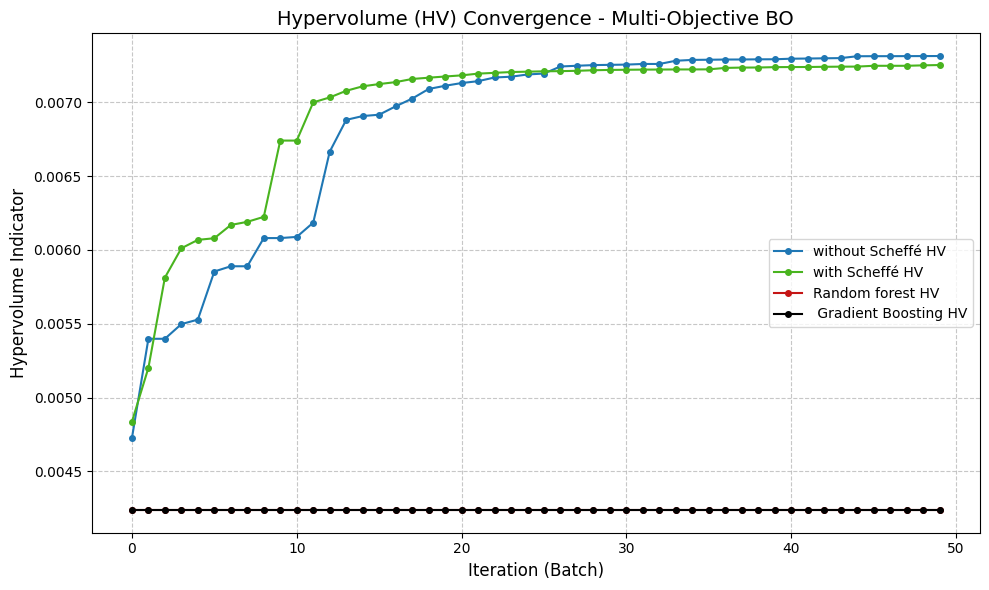

In [9]:
import json
import matplotlib.pyplot as plt

def plot_averages(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    if not data:
        return "JSON 文件中沒有數據。"
    
    hv_history = data.get('hv_history')

    return hv_history


def tree_averages(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    if not data:
        return "JSON 文件中沒有數據。"
    
    return data



base_gp_hv_history = plot_averages("D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_gp_result/synthetic_data_sparse_seed_39.json")
Scheffé_gp_hv_history = plot_averages("D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result/synthetic_data_sparse_seed_39.json")
rf_history = tree_averages("D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/tree_result/hv_history.json")
gb_history = tree_averages("D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/tree_result/hv_history.json")


# 3. 繪圖
plt.figure(figsize=(10, 6))
plt.plot(base_gp_hv_history, marker='o', linestyle='-', color='#1f77b4', markersize=4, label='without Scheffé HV')
plt.plot(Scheffé_gp_hv_history, marker='o', linestyle='-', color="#49b41f", markersize=4, label='with Scheffé HV')
plt.plot(rf_history, marker='o', linestyle='-', color="#c51515", markersize=4, label='Random forest HV')
plt.plot(gb_history, marker='o', linestyle='-', color="#000000", markersize=4, label=' Gradient Boosting HV')


# # 計算累積最大值 (Running Maximum) 以顯示收斂狀況
# running_max = [max(hv_history[:i+1]) for i in range(len(hv_history))]
# plt.step(range(len(running_max)), running_max, where='post', color='red', alpha=0.6, label='Best HV')

# 圖表格式設定
plt.title('Hypervolume (HV) Convergence - Multi-Objective BO', fontsize=14)
plt.xlabel('Iteration (Batch)', fontsize=12)
plt.ylabel('Hypervolume Indicator', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
import json

# 假設您的檔案名稱為 performance_report.json
def calculate_performance_averages(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    if not data:
        return "JSON 文件中沒有數據。"

    n = len(data)
    
    # 提取各項數值
    runtimes = [entry['runtime_sec'] for entry in data]
    cpu_mems = [entry['cpu_memory_mb'] for entry in data]
    gpu_mems = [entry.get('gpu_alloc_mb', 0) for entry in data] # 使用 get 以防某些紀錄沒用到 GPU

    # 計算平均
    avg_runtime = sum(runtimes) / n
    avg_cpu = sum(cpu_mems) / n
    avg_gpu = sum(gpu_mems) / n

    print(f"--- Scheffe mean 統計報告 (共 {n} 筆紀錄) ---")
    print(f"總執行時間: 508m 59sec")
    print(f"平均執行時間: {avg_runtime:.4f} sec")
    print(f"平均 CPU 使用量: {avg_cpu:.2f} MB")
    print(f"平均 GPU 佔用量: {avg_gpu:.2f} MB")

# 執行範例
calculate_performance_averages("D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result/final_performance_seed_39.json")

--- Scheffe mean 統計報告 (共 50 筆紀錄) ---
總執行時間: 508m 59sec
平均執行時間: 41.1660 sec
平均 CPU 使用量: 2069.58 MB
平均 GPU 佔用量: 28.26 MB
